### Mobilnets Implementation

Previous versions I used max pooling for dimensionality reduction. In this version I'll substute a Conv2d, 1x1 layer instead; reduced to 15 channels from 1024. That will allow the 1x1 to learn the object shapes while the subsequent layer learns the classes.

#### 2017-09-17
Got this version working. There is some confusion on a few classes; notably person to cat or dog. Retraining should clear this up since there were several photos in the training set (since removed) where people would appear in other classes.

Also, I need to examine whether training is needed for the 0 class (background). Ideally, this class is never represented in the generator and only the relevant classes are shown.


In [1]:
'''
Created on Aug 22, 2017

@author: jyarde
'''
from keras import backend as K
from keras.applications.mobilenet import MobileNet, relu6, DepthwiseConv2D
from keras.models import load_model, Model, Sequential
from keras.optimizers import RMSprop, Adam, SGD
from keras.engine.topology import Layer
from keras.engine import InputSpec
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, TensorBoard

from keras.layers import Input, Activation, Conv2D
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import GlobalAveragePooling2D, MaxPooling2D
from keras.layers.convolutional import Conv2DTranspose, UpSampling2D
from keras.layers.core import Reshape, Dropout
from keras.layers.core import Lambda

from PIL import Image, ImageDraw, ImageFont, ImageOps
import tensorflow as tf

import cv2
from ImageProcessing import get_viewport
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
from CameraOperations import show_grid

def run_prediction(x):
    prediction = model.predict(x, 1, True)
    return prediction


def read_config(config_file="./imagenet1000_clsid_to_human_array.json"):
    '''
      Read Configuration parameters from external file
    '''
    import json
    
    with open(config_file) as config_data:
        config = json.load(config_data)
    return config


def predict_with_mobilenet(image, model=None):
    if model is None:
        model = load_model('./mobilenet_1_0_224_tf_local.h5', 
                           custom_objects={'relu6': relu6, 'DepthwiseConv2D': DepthwiseConv2D})
    image_input = image/255.
    X = np.expand_dims(image_input, 0)
    prediction = model.predict(X, len(X), False)
    idx = np.argmax(prediction, 1)[0]
    return idx, prediction, model

def save_channels(prediction, classes=1000):
    max_prob = np.max(prediction)
    print("\n{: >3.0f} ".format(0), end="")
    for r in range(classes):
        prediction_img = prediction[0][:,:,r]*255/max_prob
        cv2.imwrite("./deconv/img{}.jpg".format(r), prediction_img)
        '''
        if r>0 and not r%10:
            term = "\n{: >3.0f} ".format(int(r/10))
        else:
            term = ","
        #print("{1: >6.2f}/{0: >4.2f}".format(np.max(prediction[0][:,:,r]),np.sum(prediction[0][:,:,r])), end=term)
        print("{0: >6.2f}".format(np.max(prediction[0][:,:,r])/np.sum(prediction[0][:,:,r])), end=term)
        '''

def deconv_layer(inputs, 
                 filters, 
                 alpha=1.0, 
                 kernel=(3, 3), 
                 strides=(2, 2), 
                 block_id=1, 
                 activation=None, 
                 use_bias=True):
    '''
        Deconvolutional layers
    '''
    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1
    filters = int(filters * alpha)
    x = Conv2DTranspose(filters, kernel,
               padding='valid',
               use_bias=use_bias,
               strides=strides,
               name='deconv_%d' % block_id,
               kernel_initializer='he_normal',
               bias_initializer='zeros')(inputs)
    #x = BatchNormalization(axis=channel_axis, name='deconv_bn_%d' % block_id)(x)
    if activation is None:
        return Activation(relu6, name='deconv_relu_%d' % block_id)(x)
    else:
        return activation(x)

    
def conv_layer(inputs, 
               filters, 
               alpha=1.0, 
               kernel=(3, 3), 
               strides=(1, 1), 
               block_id=1, 
               activation=None, 
               use_bias=False,
               padding='valid'):
    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1
    filters = int(filters * alpha)
    x = Conv2D(filters, kernel,
               padding=padding,
               use_bias=use_bias,
               strides=strides,
               name='t_conv_%d' % block_id,
               kernel_initializer='he_normal',
               bias_initializer='zeros')(inputs)
    x = BatchNormalization(axis=channel_axis, name='t_conv_bn_%d' % block_id)(x)
    if activation is None:
        return Activation(relu6, name='t_conv_relu_%d' % block_id)(x)
    else:
        return activation(x)

class CustomReshape(Layer):

    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(CustomReshape, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        super(CustomReshape, self).build(input_shape)  # Be sure to call this somewhere!

    def call(self, x):
        return tf.reshape(x, [-1, self.output_dim]) #np.reshape(x, (-1, 14)) 

    def compute_output_shape(self, input_shape):
        print("CustomReshape", input_shape)
        return (input_shape[0], self.output_dim)

    def get_config(self):
        config = {'output_dim': self.output_dim}
        base_config = super(CustomReshape, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


class BilinearUpSampling2D(Layer):

    def __init__(self, output_dim, scale_factor, **kwargs):
        self.output_dim   = output_dim
        self.scale_factor = scale_factor
        super(BilinearUpSampling2D, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        super(BilinearUpSampling2D, self).build(input_shape)  # Be sure to call this somewhere!

    def call(self, x):
        input_size = tf.shape(x)
        size = (self.scale_factor*input_size[1], self.scale_factor*input_size[2])
        new_size = tf.convert_to_tensor(size, dtype=tf.int32)
        return tf.image.resize_images(x, new_size)
        #return tf.reshape(x, [-1, self.output_dim]) 

    def compute_output_shape(self, input_shape):
        print("BilinearUpSampling2D", input_shape)
        return input_shape[:-1] + (self.output_dim,)

    def get_config(self):
        config = {'output_dim': self.output_dim, 'scale_factor': self.scale_factor}
        base_config = super(BilinearUpSampling2D, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


def generate_magic_kernel(classes=15, channels=15):
    magic_kernel = np.array([[0.25,0.75,0.75,0.25],
                         [0.25,0.75,0.75,0.25],
                         [0.25,0.75,0.75,0.25],
                         [0.25,0.75,0.75,0.25]])
    kernel = []
    for c in range(channels):
        kernel_channel
        for cl in range(classes):
            kernel_channel.append(magic_kernel)
        kernel.append(kernel_channel)
    return np.array(kernel)


def generate_2class_mobilenet(source_model, classes=2, deconv=True, dropout=1e-3):
    '''
        Reduce Mobilenet output classes to 2 so it can be trained on Kitti data
    '''
    w_final_conv2d = source_model.get_layer("conv_preds").get_weights()
    
    # Create a new top to take any size input
    new_input = Input(shape=(None, None, 3))
    #new_input = Input(shape=(256, 256, 3))
    
    '''
        Remove top and add Conv2D layers for reduction and recognition
    '''
    mobilenet = MobileNet(include_top=False, 
                      weights='imagenet', 
                      input_tensor=new_input)

    x = mobilenet.layers[-1].output
    #x = Dropout(dropout, name='dropout_final')(x)
    act = Activation('softmax', name='act_softmax')
    x = conv_layer  (x, 
                     classes, 
                     alpha=1.0, 
                     kernel=(3, 3), 
                     strides=(1, 1), 
                     padding='same',
                     block_id=1, 
                     activation=act)
    #x = Lambda(lambda a: print(a.shape))(x)
    x = MaxPooling2D(pool_size=(8, 8), strides=(8, 8))(x)
    x = CustomReshape(classes, name='reshape_2')(x)
    #compose the combined model with the new top
    new_model = Model(mobilenet.input, x)
    for i in range(len(new_model.layers)-5):
        new_model.layers[i].trainable = False

    new_model.summary()
    new_model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.01), metrics=['accuracy'])
    new_model.save('mobilenet_2class_model_updated.h5')
    return new_model


def generate_2class_fcn(source_model, classes=2, deconv=True, dropout=1e-3):
    '''
        Make Mobilenet fully convolutional with any size input and
        segmentation output. source_model provides fully loaded Mobilenet 
        so we can extract its weights for the FCN model
        
        Return the fully convolutional model.
    '''
    x = source_model.layers[-3].output
    sig = Activation('softmax', name='act_softmax2')
    trainable_layers = 0
    if deconv:
        x = BilinearUpSampling2D(scale_factor=4, output_dim=classes, name='upscore_1')(x)
        block_id = 1
        x = Conv2DTranspose(classes, 
                            (2, 2), 
                            activation='softmax', 
                            padding='same', 
                            use_bias=False, 
                            strides=(1,1), 
                            name='deconv_%d' % block_id, 
                            kernel_initializer='he_normal', 
                            bias_initializer='zeros')(x)
        block_id = 2
        x = BilinearUpSampling2D(scale_factor=4, output_dim=classes, name='upscore_2')(x)
        x = Conv2DTranspose(classes, 
                            (2, 2), 
                            activation='softmax', 
                            padding='same', 
                            use_bias=False, 
                            strides=(1,1), 
                            name='deconv_%d' % block_id, 
                            kernel_initializer='he_normal', 
                            bias_initializer='zeros')(x)
        block_id = 3
        x = Conv2DTranspose(classes, 
                            (4, 4), 
                            activation='softmax', 
                            padding='same', 
                            use_bias=False, 
                            strides=(2,2), 
                            name='deconv_%d' % block_id, 
                            kernel_initializer='he_normal', 
                            bias_initializer='zeros')(x)

        trainable_layers = 8
    else:
        x = UpSampling2D(size=2, data_format='channels_last')(x)

    #
    #compose the combined model with the new top
    new_model = Model(source_model.input, x)
    for i in range(len(new_model.layers) - trainable_layers):
        new_model.layers[i].trainable = False    
    new_model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.01), metrics=['accuracy'])
    new_model.summary()
    return new_model


def preprocess_image(image, normalize=False, pad=0):
    '''
    Normalize is divide by 255.
    pad is pad to multiples of 'pad'
    '''
    w = image.size[0]
    h = image.size[1]
    img = None
    if pad > 0:
        w_pad = w % pad
        h_pad = h % pad
        if w_pad > h_pad:
            img = np.asarray(ImageOps.expand(image, w_pad, 0))
        else:
            img = np.asarray(ImageOps.expand(image, h_pad, 0))
    else:
        img = np.asarray(image)
    if normalize:
        img = img/255.
    return img


def load_img(file, normalize=False, pad=0):
    '''
     Load images and always convert to RGB representation
     If 'normalize' is True, then divide by 255.
     If 'pad' is more than 0, pad the image to a multiple of the provided number
    '''
    image = Image.open(file)
    if image.mode is not 'RGB':
        image = image.convert('RGB')
    return preprocess_image(image, normalize, pad)


def pad_image(image, thickness=(1,1), padding=(1,1)):
    return np.lib.pad(image, thickness, 'constant', constant_values=padding)


def predict_with_model(image, model=None):
    image_input = image
    X = np.expand_dims(image_input, 0)
    prediction = model.predict(X, len(X), True)
    idx = np.argmax(prediction)
    return idx, prediction


def prediction_heatmaps(image, model, classes=2):
    result = predict_with_model(image, model)
    #result = None
    #image_input = image/255.
    #X = np.expand_dims(image_input, 0)
    #prediction = model.predict(X, 1, False)
    #pred = prediction[0]
    pred = result[1][0]
    heatmap = np.concatenate([pad_image(pred[:,:,c], thickness=(1,1)) for c in range(classes)], axis=1)
    return heatmap


input_size = (256,256)
fcn_size   = (512,512)
classes    = 2
model_file = "./training/classifier_72-0.838-0.029.hdf5"
fcn_model_file = "./training/fcn_weights_13-0.940-0.050.hdf5"
class_names = ["background", "road"]

mobilenet_model = load_model('./mobilenet_1_0_224_tf_local.h5', 
                             custom_objects={'relu6': relu6, 
                                             'DepthwiseConv2D': DepthwiseConv2D})

classifier = load_model(model_file, 
                        custom_objects={'relu6': relu6, 
                                        'DepthwiseConv2D': DepthwiseConv2D, 
                                        'CustomReshape': CustomReshape})

segmenter = load_model(fcn_model_file, 
                       custom_objects={'relu6': relu6, 
                                       'DepthwiseConv2D': DepthwiseConv2D, 
                                       'CustomReshape': CustomReshape, 
                                       'BilinearUpSampling2D': BilinearUpSampling2D})

conv_model = Model(segmenter.input, segmenter.layers[-6].output)

def training_callbacks(folder="./training/", name_prefix="classifier_", batch=30, use_val=True):
    '''
    Generate callbacks to checkpoint model during training and reduce the learning rate on plateau
    'use_val' decides whether to use training or validation statistics for decisions and reporting
    '''
    #filepath = "./training/weights-improvement-{epoch:02d}-{val_acc:.3f}-{val_loss:.3f}.hdf5"
    filepath = folder+name_prefix+"{epoch:02d}-{val_acc:.3f}-{val_loss:.3f}.hdf5"
    monitor_checkpoint = 'val_acc'
    monitor_reduce_lr = 'val_loss'
    if not use_val:
        filepath = folder+name_prefix+"{epoch:02d}-{acc:.3f}-{loss:.3f}.hdf5"
        monitor_checkpoint = 'acc'
        monitor_reduce_lr = 'loss'
    checkpoint = ModelCheckpoint(filepath, 
                                 monitor=monitor_checkpoint, 
                                 verbose=0, 
                                 save_best_only=True, 
                                 save_weights_only=False, 
                                 mode='auto')
    reduce_lr = ReduceLROnPlateau(monitor=monitor_reduce_lr, 
                                  factor=0.25, patience=3, 
                                  min_lr=0.0001, 
                                  mode='min', 
                                  verbose=0)
    tensorboard = TensorBoard(log_dir='./tensorboard', 
                              histogram_freq=0, 
                              batch_size=batch, 
                              write_graph=True, 
                              write_grads=False, 
                              write_images=False, 
                              embeddings_freq=0, 
                              embeddings_layer_names=None, 
                              embeddings_metadata=None)
    callbacks_list = [checkpoint, reduce_lr, tensorboard]
    return callbacks_list

def extract_heatmap_class(heatmap, classid, classes=2):
    frame_width = heatmap.shape[1]/classes
    start = int(classid*frame_width)
    end   = int(start + frame_width)
    return heatmap[:,start:end]

def process_image(img_file, fcn, conv, targets=[0,1]):
    '''
    Show heatmaps for image targets from deconvolutional model and pure fully convolutional model
    targets is a list of class ids to show
    '''
    img = load_img(img_file, normalize=False, pad=0)
    print("Image Dimensions", img.shape)
    target_fcn = None
    
    if fcn is not None:
        heatmap = prediction_heatmaps(img/255., fcn)
        plt.figure(figsize=(15,2))
        p = plt.imshow(heatmap, cmap="hot")
        print("Heatmap Dimensions", heatmap.shape)
        names = [class_names[n] for n in targets]
        names.insert(0, "Source")
        target_fcn = [extract_heatmap_class(heatmap, c) for c in targets]
        target_fcn.insert(0, img)
        show_grid(target_fcn, names, cmap_mono="hot")

    if conv is not None:
        heatmap = prediction_heatmaps(img/255., conv)
        plt.figure(figsize=(15,2))
        p = plt.imshow(heatmap, cmap="hot")
        print("Heatmap Dimensions", heatmap.shape)
        names = [class_names[n] for n in targets]
        names.insert(0, "Source")
        target = [extract_heatmap_class(heatmap, c) for c in targets]
        target.insert(0, img)
        show_grid(target, names, cmap_mono="hot")
    return target_fcn


/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


CustomReshape (None, None, None, 15)


/usr/local/lib/python3.6/dist-packages/keras/models.py:318: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


BilinearUpSampling2D (None, None, None, 2)
BilinearUpSampling2D (None, None, None, 2)


In [2]:
def generate_2class_fcn(source_model, classes=2, deconv=True, dropout=1e-3):
    '''
        Make Mobilenet fully convolutional with any size input and
        segmentation output. source_model provides fully loaded Mobilenet 
        so we can extract its weights for the FCN model
        
        Return the fully convolutional model.
    '''
    x = source_model.layers[-3].output
    sig = Activation('softmax', name='act_softmax2')
    trainable_layers = 0
    if deconv:
        block_id = 1
        #x = BilinearUpSampling2D(scale_factor=2, output_dim=classes, name='upscore_%d' % block_id)(x)
        x = Conv2DTranspose(classes, 
                            (2, 2), 
                            activation='softmax', 
                            padding='same', 
                            use_bias=False, 
                            strides=(2,2), 
                            name='deconv_%d' % block_id, 
                            kernel_initializer='he_normal', 
                            bias_initializer='zeros')(x)
        block_id = 2
        #x = BilinearUpSampling2D(scale_factor=2, output_dim=classes, name='upscore_%d' % block_id)(x)
        x = Conv2DTranspose(classes, 
                            (3, 3), 
                            activation='softmax', 
                            padding='same', 
                            use_bias=False, 
                            strides=(2,2), 
                            name='deconv_%d' % block_id, 
                            kernel_initializer='he_normal', 
                            bias_initializer='zeros')(x)
        block_id = 3
        #x = BilinearUpSampling2D(scale_factor=2, output_dim=classes, name='upscore_%d' % block_id)(x)
        x = Conv2DTranspose(classes, 
                            (3, 3), 
                            activation='softmax', 
                            padding='same', 
                            use_bias=False, 
                            strides=(2,2), 
                            name='deconv_%d' % block_id, 
                            kernel_initializer='he_normal', 
                            bias_initializer='zeros')(x)
        block_id = 4
        #x = BilinearUpSampling2D(scale_factor=2, output_dim=classes, name='upscore_%d' % block_id)(x)
        x = Conv2DTranspose(classes, 
                            (3, 3), 
                            activation='softmax', 
                            padding='same', 
                            use_bias=False, 
                            strides=(2,2), 
                            name='deconv_%d' % block_id, 
                            kernel_initializer='he_normal', 
                            bias_initializer='zeros')(x)
        block_id = 5
        #x = BilinearUpSampling2D(scale_factor=2, output_dim=classes, name='upscore_%d' % block_id)(x)
        x = Conv2DTranspose(classes, 
                            (3, 3), 
                            activation='softmax', 
                            padding='same', 
                            use_bias=False, 
                            strides=(2,2), 
                            name='deconv_%d' % block_id, 
                            kernel_initializer='he_normal', 
                            bias_initializer='zeros')(x)

        trainable_layers = 16
    else:
        x = UpSampling2D(size=2, data_format='channels_last')(x)

    #
    #compose the combined model with the new top
    new_model = Model(source_model.input, x)
    for i in range(len(new_model.layers) - trainable_layers):
        new_model.layers[i].trainable = False    
    new_model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.01), metrics=['accuracy'])
    new_model.summary()
    return new_model

classifier = generate_2class_mobilenet(mobilenet_model, classes=2)
fcn_model  = generate_2class_fcn(classifier, deconv=True)


/usr/local/lib/python3.6/dist-packages/keras/applications/mobilenet.py:224: UserWarning: MobileNet shape is undefined. Weights for input shape (224, 224) will be loaded.
  warnings.warn('MobileNet shape is undefined.'


17227776/17225924 [==============================] - 3s 0us/step
CustomReshape (None, None, None, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, None, None, 3)     0         
_________________________________________________________________
conv1 (Conv2D)               (None, None, None, 32)    864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, None, None, 32)    128       
_________________________________________________________________
conv1_relu (Activation)      (None, None, None, 32)    0         
_________________________________________________________________
conv_pad_1 (ZeroPadding2D)   (None, None, None, 32)    0         
_________________________________________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, None, None, 3)     0         
_________________________________________________________________
conv1 (Conv2D)               (None, None, None, 32)    864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, None, None, 32)    128       
_________________________________________________________________
conv1_relu (Activation)      (None, None, None, 32)    0         
_________________________________________________________________
conv_pad_1 (ZeroPadding2D)   (None, None, None, 32)    0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)    288       
__________

### Train the Fully-convolutional model



In [5]:
from fcnprocessing import ImageDataGenerator

#classifier = generate_2class_mobilenet(mobilenet_model, classes=2)
#fcn_model  = generate_2class_fcn(classifier, deconv=True)

# we create two instances with the same arguments
shift = 0.2
data_gen_args = dict(rescale=1./255,
                     horizontal_flip=True,
                     vertical_flip=True,
                     rotation_range=45)

'''
                     shear_range=0.2,
                     zoom_range=0.2,
                     width_shift_range=shift,
                     height_shift_range=shift, 
'''

image_datagen = ImageDataGenerator(**data_gen_args)
# Provide the same seed and keyword arguments to the fit and flow methods
seed = 1
root = "/home/jyarde/Udacity/CarND-Semantic-Segmentation/data/data_road/fcn_training/"
#root = "/home/jyarde/Udacity/CarND-Semantic-Segmentation/data/data_road/fcn_15/"
image_dir = root+"input/"
mask_dir  = root+"output/"
classes = 2
multiplier = 4
batch = 8

image_generator = image_datagen.flow_from_directory(image_dir,
                                                    class_mode='sparse_mask',
                                                    batch_size=batch,
                                                    seed=seed, 
                                                    target_size=(512, 512))

fcn_model.fit_generator(image_generator,
                        steps_per_epoch=50,
                        verbose=1,
                        epochs=5,
                        callbacks=training_callbacks(batch=batch, name_prefix="fcn_weights_", use_val=False))
fcn_model.save('fcn_classifier_model.hdf5')


Found 289 images belonging to 1 classes.
Epoch 1/5
50/50 [==============================] - 167s 3s/step - loss: 0.1639 - acc: 0.8290
Epoch 2/5
50/50 [==============================] - 165s 3s/step - loss: 0.1463 - acc: 0.8309
Epoch 3/5
50/50 [==============================] - 162s 3s/step - loss: 0.1451 - acc: 0.8306
Epoch 4/5
50/50 [==============================] - 165s 3s/step - loss: 0.1445 - acc: 0.8293
Epoch 5/5
50/50 [==============================] - 165s 3s/step - loss: 0.1035 - acc: 0.8590


### Model Testing

Image Dimensions (375, 1242, 3)
1/1 [==============================] - 1s 1s/step
Heatmap Dimensions (386, 2500)


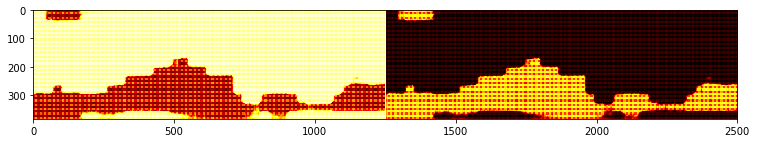

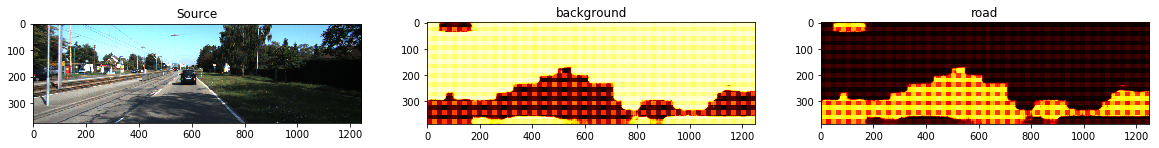

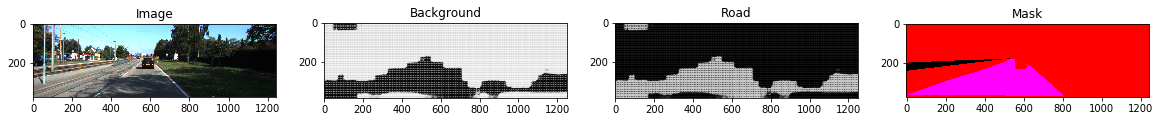

In [6]:
img_file = "/home/jyarde/Udacity/CarND-Semantic-Segmentation/data/data_road/fcn_training/input/1/um_000030.png"
mask_file = "/home/jyarde/Udacity/CarND-Semantic-Segmentation/data/data_road/fcn_training/output/1/um_road_000030.png"

img = load_img(img_file, normalize=False, pad=0)
fcn_output = process_image(img_file, fcn_model, None, targets=[0,1])
img_mask = load_img(mask_file, normalize=False, pad=0)
fcn_output.append(img_mask)
show_grid(fcn_output, ["Image", "Background", "Road", "Mask"])